<a href="https://colab.research.google.com/github/FourLevel/Machine-Learning-and-Financial-Applications/blob/main/Homework%201_TSMC%20price%20prediction/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 1: TSMC Stock Prediction
### Name: M11218014 王士誠 Finance

- In this case study we will use various supervised learning-based models to predict the stock price of Taiwan Semiconductor using correlated assets and its own historical data.  
We will refer to the first actual case and change the analysis company to TSMC and write a page of our conclusion.  

- The stock price associated with TSMC is NVIDIA.  
The relevant exchange rates are the USD and RMB.  
The indices to consider are the Taiwan Weighted Index, the Philadelphia Semiconductor Index and VIX.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Machine Learning models-scikit-learn](#4.3.1)
        * [5.3.2 Time Series based Models-ARIMA and LSTM](#4.3.2)
* [6. Model Tuning and grid search](#5)
* [7. Finalise the model](#6)
    * [7.1. Result on the test dataset](#6.1)
    * [7.2. Save Model for Later Use](#6.2)     

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the Taiwan Semiconductor stock (TSMC.TW) is the predicted variable. We need to understand what affects Taiwan Semiconductor stock price and hence incorporate as much information into the model.

For this case study, other than the historical data of TSMC.TW, the independent variables used are the following potentially correlated assets:
* Stock: NVIDIA (NVDA.US)
* Currency: USD/TWD (DEXTAUS) and RMB/TWD (Calculated by DEXTAUS and DEXCHUS)
* Indices: Taiwan Weighted Index (^TWII), Philadelphia Semiconductor Index (^SOX) and VIX (^VIX)


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [78]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Deep Learning Models
!pip install tensorflow
!pip install scikeras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from scikeras.wrappers import KerasRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [79]:
# Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader.

All data can be found in yahoo finance, so we don't use FRED economic data here.

In [80]:
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
import pandas as pd

stk_tickers = ['2330.TW', 'NVDA'] # Download from yahoo finance
ccy_tickers = ['DEXCHUS', 'DEXTAUS'] # Download from fred, for calculating the RMB/TWD
idx_tickers = ['^TWII', '^SOX', '^VIX'] # Download from yahoo finance

# Download data using yfinance for stock tickers and index tickers
stk_data = yf.download(stk_tickers, period='max') # Download maximum available data
idx_data = yf.download(idx_tickers, period='max') # Download maximum available data

# Continue to use pandas_datareader for exchange rates from fred
ccy_data = web.DataReader(ccy_tickers, 'fred')

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed


Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [81]:
return_period = 5

We now define our Y series and our X series

Y: TSMC **Future** Returns

X:

    a. NVIDIA 5 Business Day Returns    
    b. USD/TWD 5 Business Day Returns    
    c. RMB/TWD 5 Business Day Returns    
    d. Taiwan Weighted Index 5 Business Day Returns    
    e. Philadelphia Semiconductor Index 5 Business Day Returns
    f. VIX 5 Business Day Returns
    g. TSMC 5 Business Day Returns    
    h. TSMC 15 Business Day Returns    
    i. TSMC 30 Business Day Returns    
    j. TSMC 60 Business Day Returns

We remove the TSMC past returns when we use the Time series models.

In [82]:
# 發現 stk_data and idx_data 為 MultiIndex 結構
print(stk_data.columns)
print()
print(ccy_data.columns)
print()
print(idx_data.columns)

MultiIndex([( 'Close', '2330.TW'),
            ( 'Close',    'NVDA'),
            (  'High', '2330.TW'),
            (  'High',    'NVDA'),
            (   'Low', '2330.TW'),
            (   'Low',    'NVDA'),
            (  'Open', '2330.TW'),
            (  'Open',    'NVDA'),
            ('Volume', '2330.TW'),
            ('Volume',    'NVDA')],
           names=['Price', 'Ticker'])

Index(['DEXCHUS', 'DEXTAUS'], dtype='object')

MultiIndex([( 'Close',  '^SOX'),
            ( 'Close', '^TWII'),
            ( 'Close',  '^VIX'),
            (  'High',  '^SOX'),
            (  'High', '^TWII'),
            (  'High',  '^VIX'),
            (   'Low',  '^SOX'),
            (   'Low', '^TWII'),
            (   'Low',  '^VIX'),
            (  'Open',  '^SOX'),
            (  'Open', '^TWII'),
            (  'Open',  '^VIX'),
            ('Volume',  '^SOX'),
            ('Volume', '^TWII'),
            ('Volume',  '^VIX')],
           names=['Price', 'Ticker'])


In [83]:
# 新增欄位計算 RMB/TWD = DEXTAUS / DEXCHUS
ccy_data['DEXTACH'] = ccy_data['DEXTAUS'] / ccy_data['DEXCHUS']

In [84]:
Y = np.log(stk_data.loc[:, ('Close', '2330.TW')]).diff(return_period).shift(-return_period)
print(Y.name)
Y.name = 'TSMC_pred'
print(Y.name)

('Close', '2330.TW')
TSMC_pred


In [85]:
X1 = np.log(stk_data.loc[:, ('Close', 'NVDA')]).diff(return_period)
X1 = X1.to_frame()
X1.columns = X1.columns.droplevel(level=0) # 移除 MultiIndex 中 Close 的 level

X2 = np.log(ccy_data).diff(return_period)
X2 = X2.rename(columns={'DEXCHUS': 'USD/RMB', 'DEXTAUS': 'USD/TWD', 'DEXTACH': 'RMB/TWD'})
X2 = X2.drop(columns=['USD/RMB'])

X3 = np.log(idx_data.loc[:, ('Close', ('^TWII', '^SOX', '^VIX'))]).diff(return_period)
X3.columns = X3.columns.droplevel(level=0)
X3 = X3.rename(columns={'^TWII': 'TWII', '^SOX': 'SOX', '^VIX': 'VIX'})

X4 = pd.concat([np.log(stk_data.loc[:, ('Close', '2330.TW')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['TSMC_DT', 'TSMC_3DT', 'TSMC_6DT', 'TSMC_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Let's have a look at the dataset we have

In [86]:
pd.set_option('display.precision', 3)
dataset.describe()

,TSMC_pred,NVDA,USD/TWD,RMB/TWD,TWII,SOX,VIX,TSMC_DT,TSMC_3DT,TSMC_6DT,TSMC_12DT
count,157.000,157.000,1.570e+02,1.570e+02,157.000,157.000,157.000,157.000,157.000,157.000,157.000
mean,0.008,0.014,3.791e-04,7.735e-04,0.003,0.007,-0.010,0.005,0.014,0.029,0.052
std,0.037,0.066,6.338e-03,5.766e-03,0.025,0.046,0.146,0.039,0.068,0.099,0.137
min,-0.070,-0.251,-3.271e-02,-1.484e-02,-0.088,-0.123,-0.447,-0.113,-0.181,-0.212,-0.297
25%,-0.017,-0.032,-2.821e-03,-2.630e-03,-0.010,-0.021,-0.101,-0.018,-0.029,-0.037,-0.035
50%,0.003,0.015,6.998e-04,6.520e-04,0.006,0.006,-0.019,0.004,0.007,0.018,0.042
75%,0.032,0.054,3.716e-03,4.210e-03,0.018,0.035,0.092,0.029,0.054,0.080,0.134
max,0.148,0.214,2.380e-02,2.289e-02,0.069,0.139,0.449,0.132,0.251,0.331,0.395


In [87]:
dataset.head()

,TSMC_pred,NVDA,USD/TWD,RMB/TWD,TWII,SOX,VIX,TSMC_DT,TSMC_3DT,TSMC_6DT,TSMC_12DT
2020-04-08,0.009,0.094,-0.006,-0.001,0.048,0.139,-0.275,0.049,0.101,-0.101,-0.167
2020-04-30,-0.023,0.029,-0.012,-0.012,0.059,0.039,-0.192,0.030,0.073,0.205,-0.078
2020-05-11,-0.037,0.102,0.002,-0.003,0.027,0.066,-0.266,0.020,-0.010,0.118,-0.087
2020-05-20,0.008,0.142,0.002,0.002,-0.003,0.085,-0.231,-0.010,-0.017,0.031,-0.070
2020-05-29,0.065,-0.017,-0.002,-0.003,0.012,0.027,-0.023,0.000,-0.019,-0.048,-0.066


<a id='2.2'></a>
## 3.2. Data Visualization

Next, let's look at the distribution of the data over the entire period

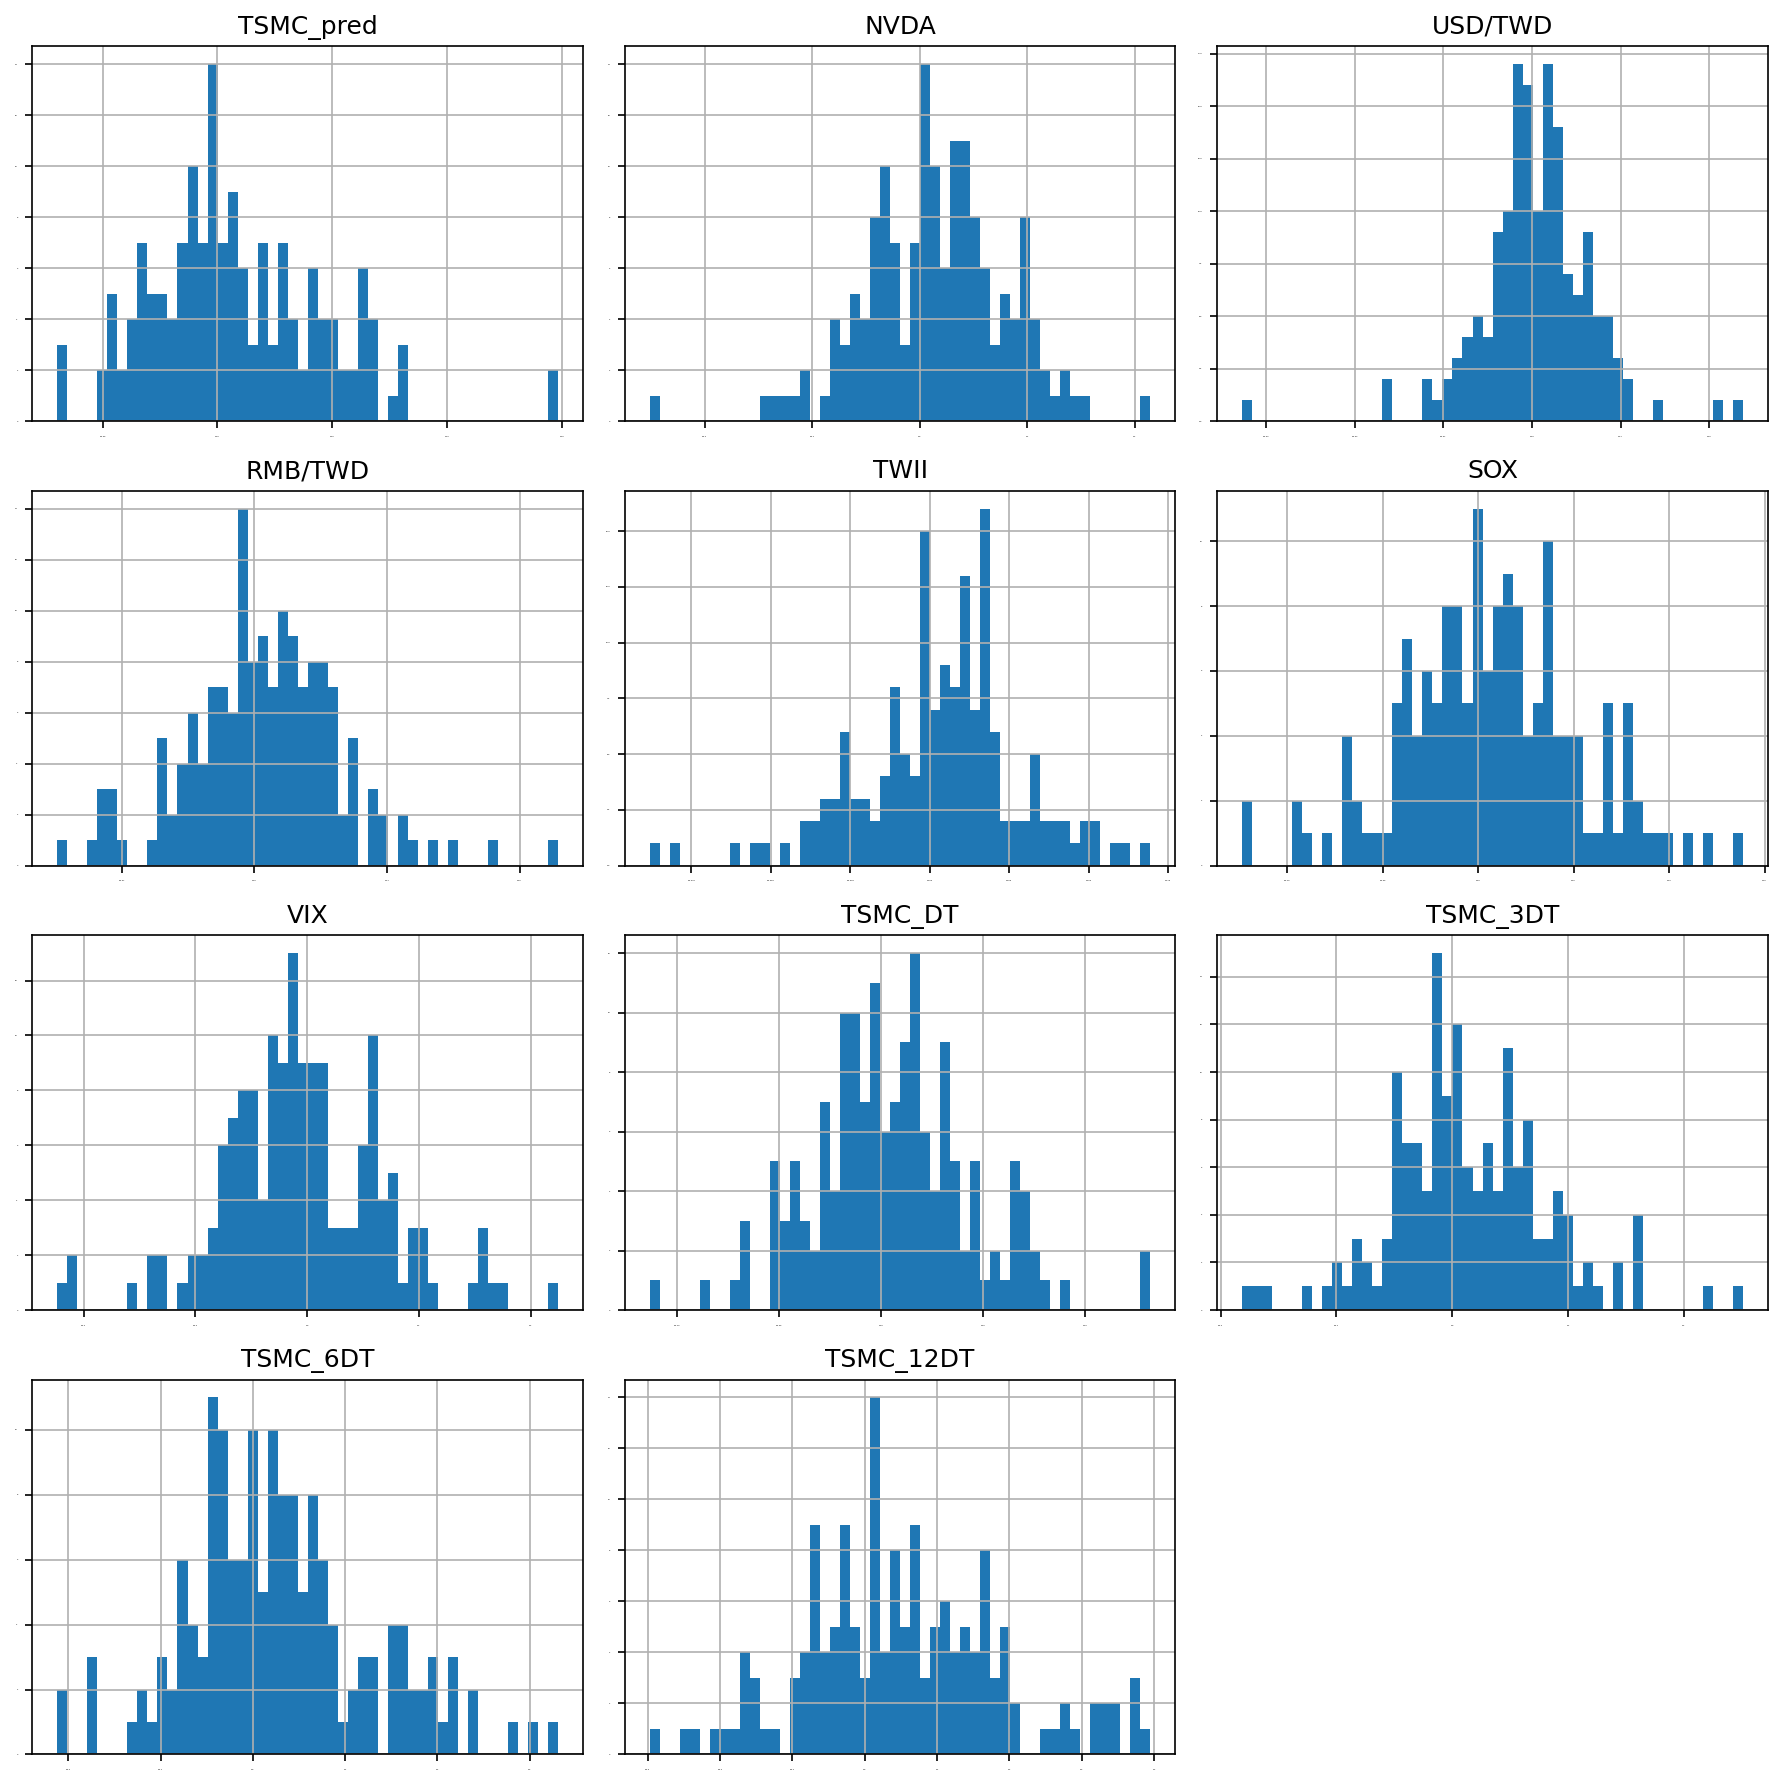

In [88]:
pyplot.rcParams['figure.dpi'] = 150  # 設定圖形全域變數 dpi 為 150
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
pyplot.tight_layout()  # 避免圖表元素重疊、提高圖表空間利用率
pyplot.show()

The above histogram shows the distribution for each series individually.  
Next, let's look at the density distribution over the same x axis scale.

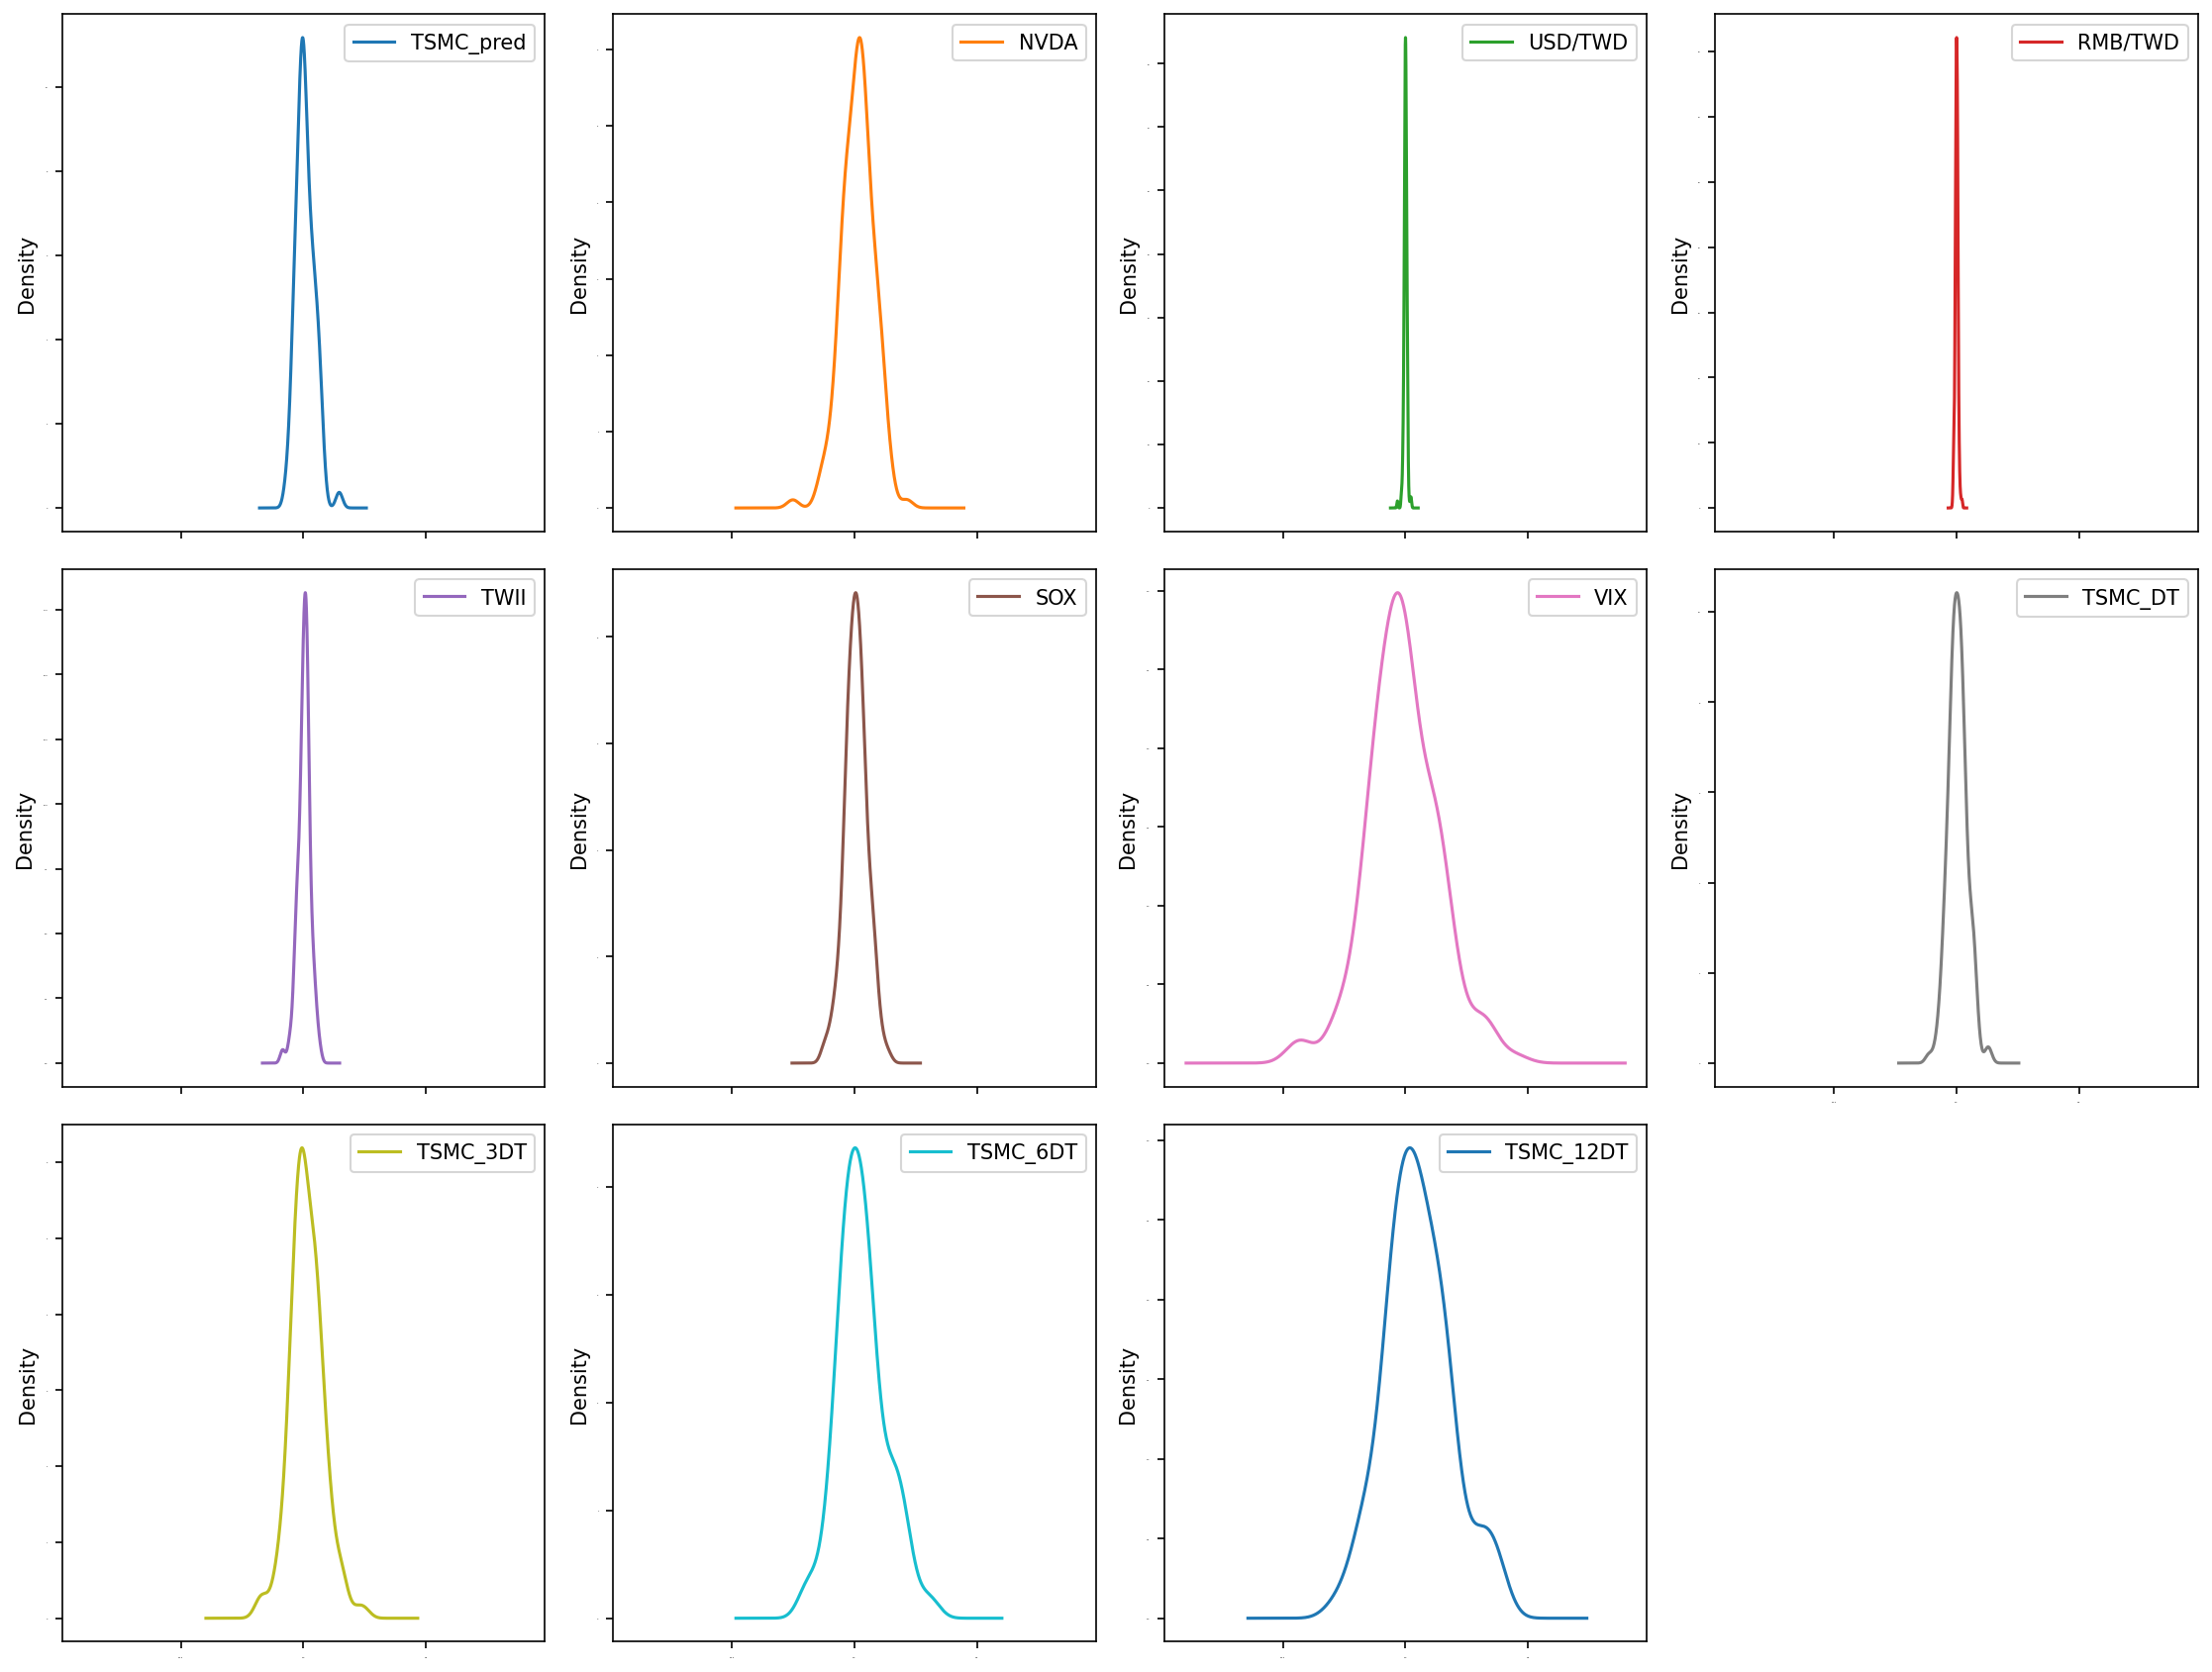

In [89]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.tight_layout()
pyplot.show()

We can see that the VIX has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

<Axes: title={'center': 'Correlation Matrix'}>

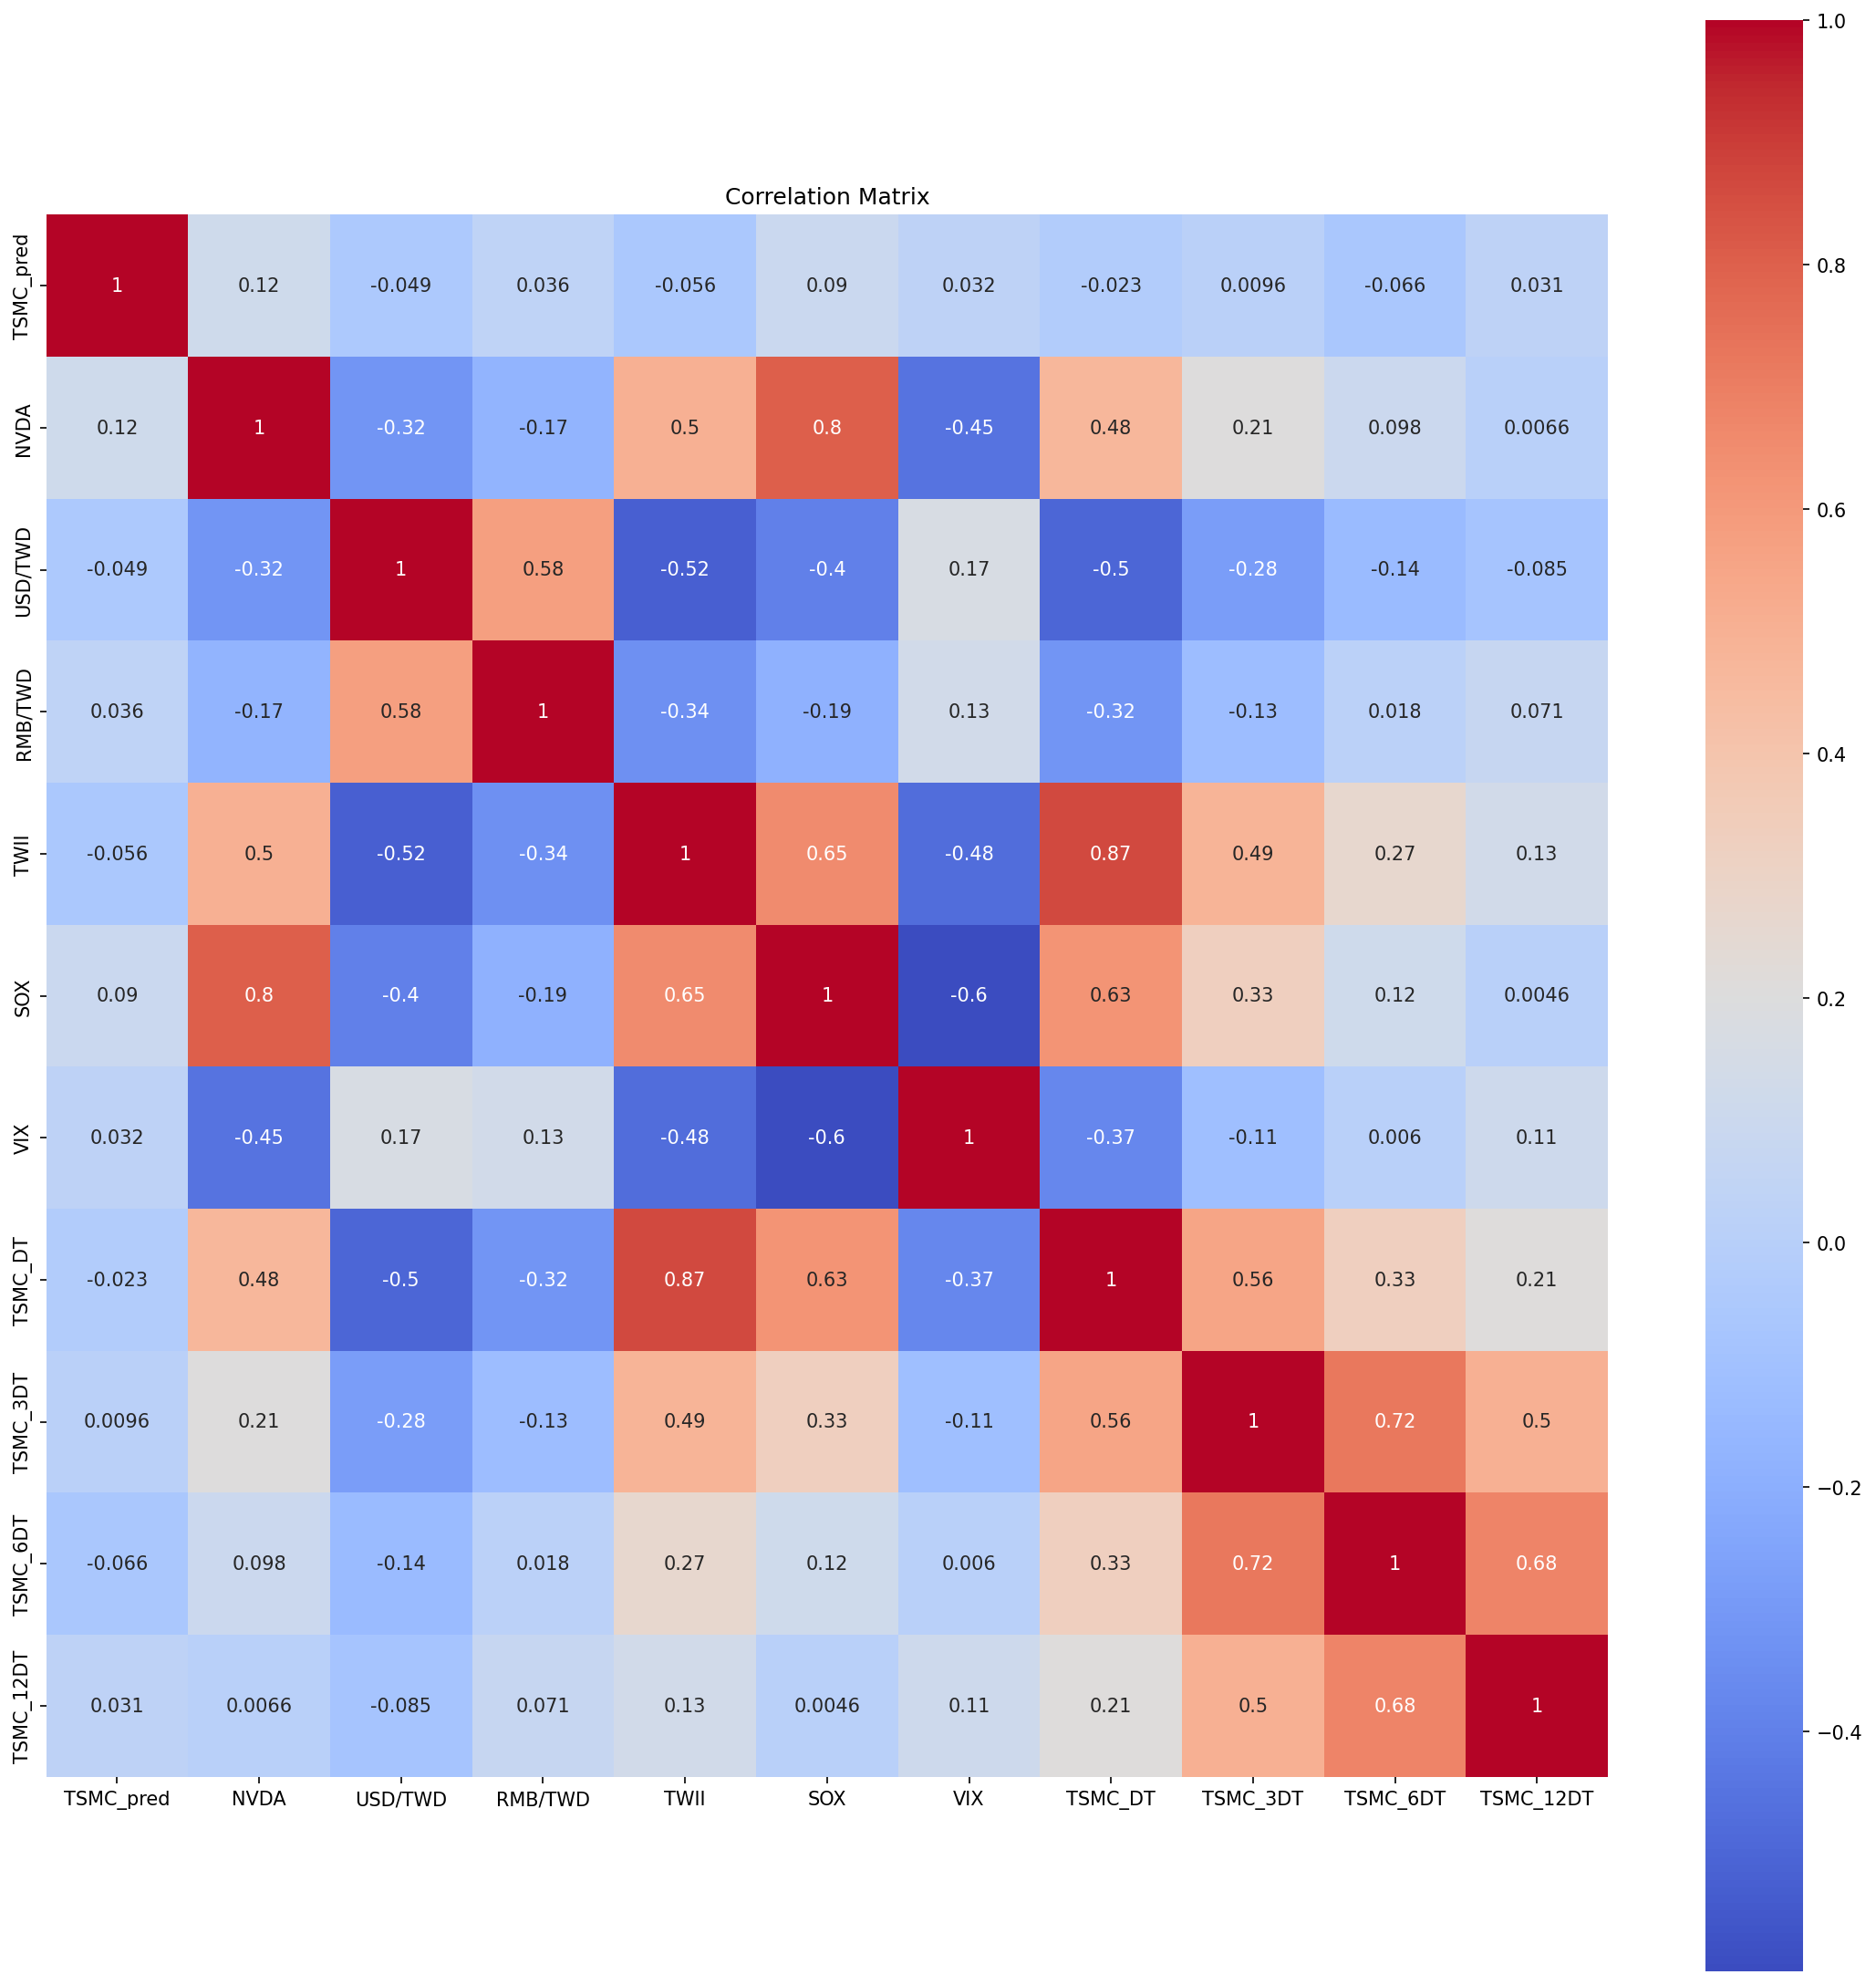

In [90]:
correlation = dataset.corr()
pyplot.figure(figsize=(15, 15))
pyplot.title('Correlation Matrix')
pyplot.tight_layout()
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='coolwarm')

Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15 days, 30 days and 60 days return of TSMC.

<Figure size 2250x2250 with 0 Axes>

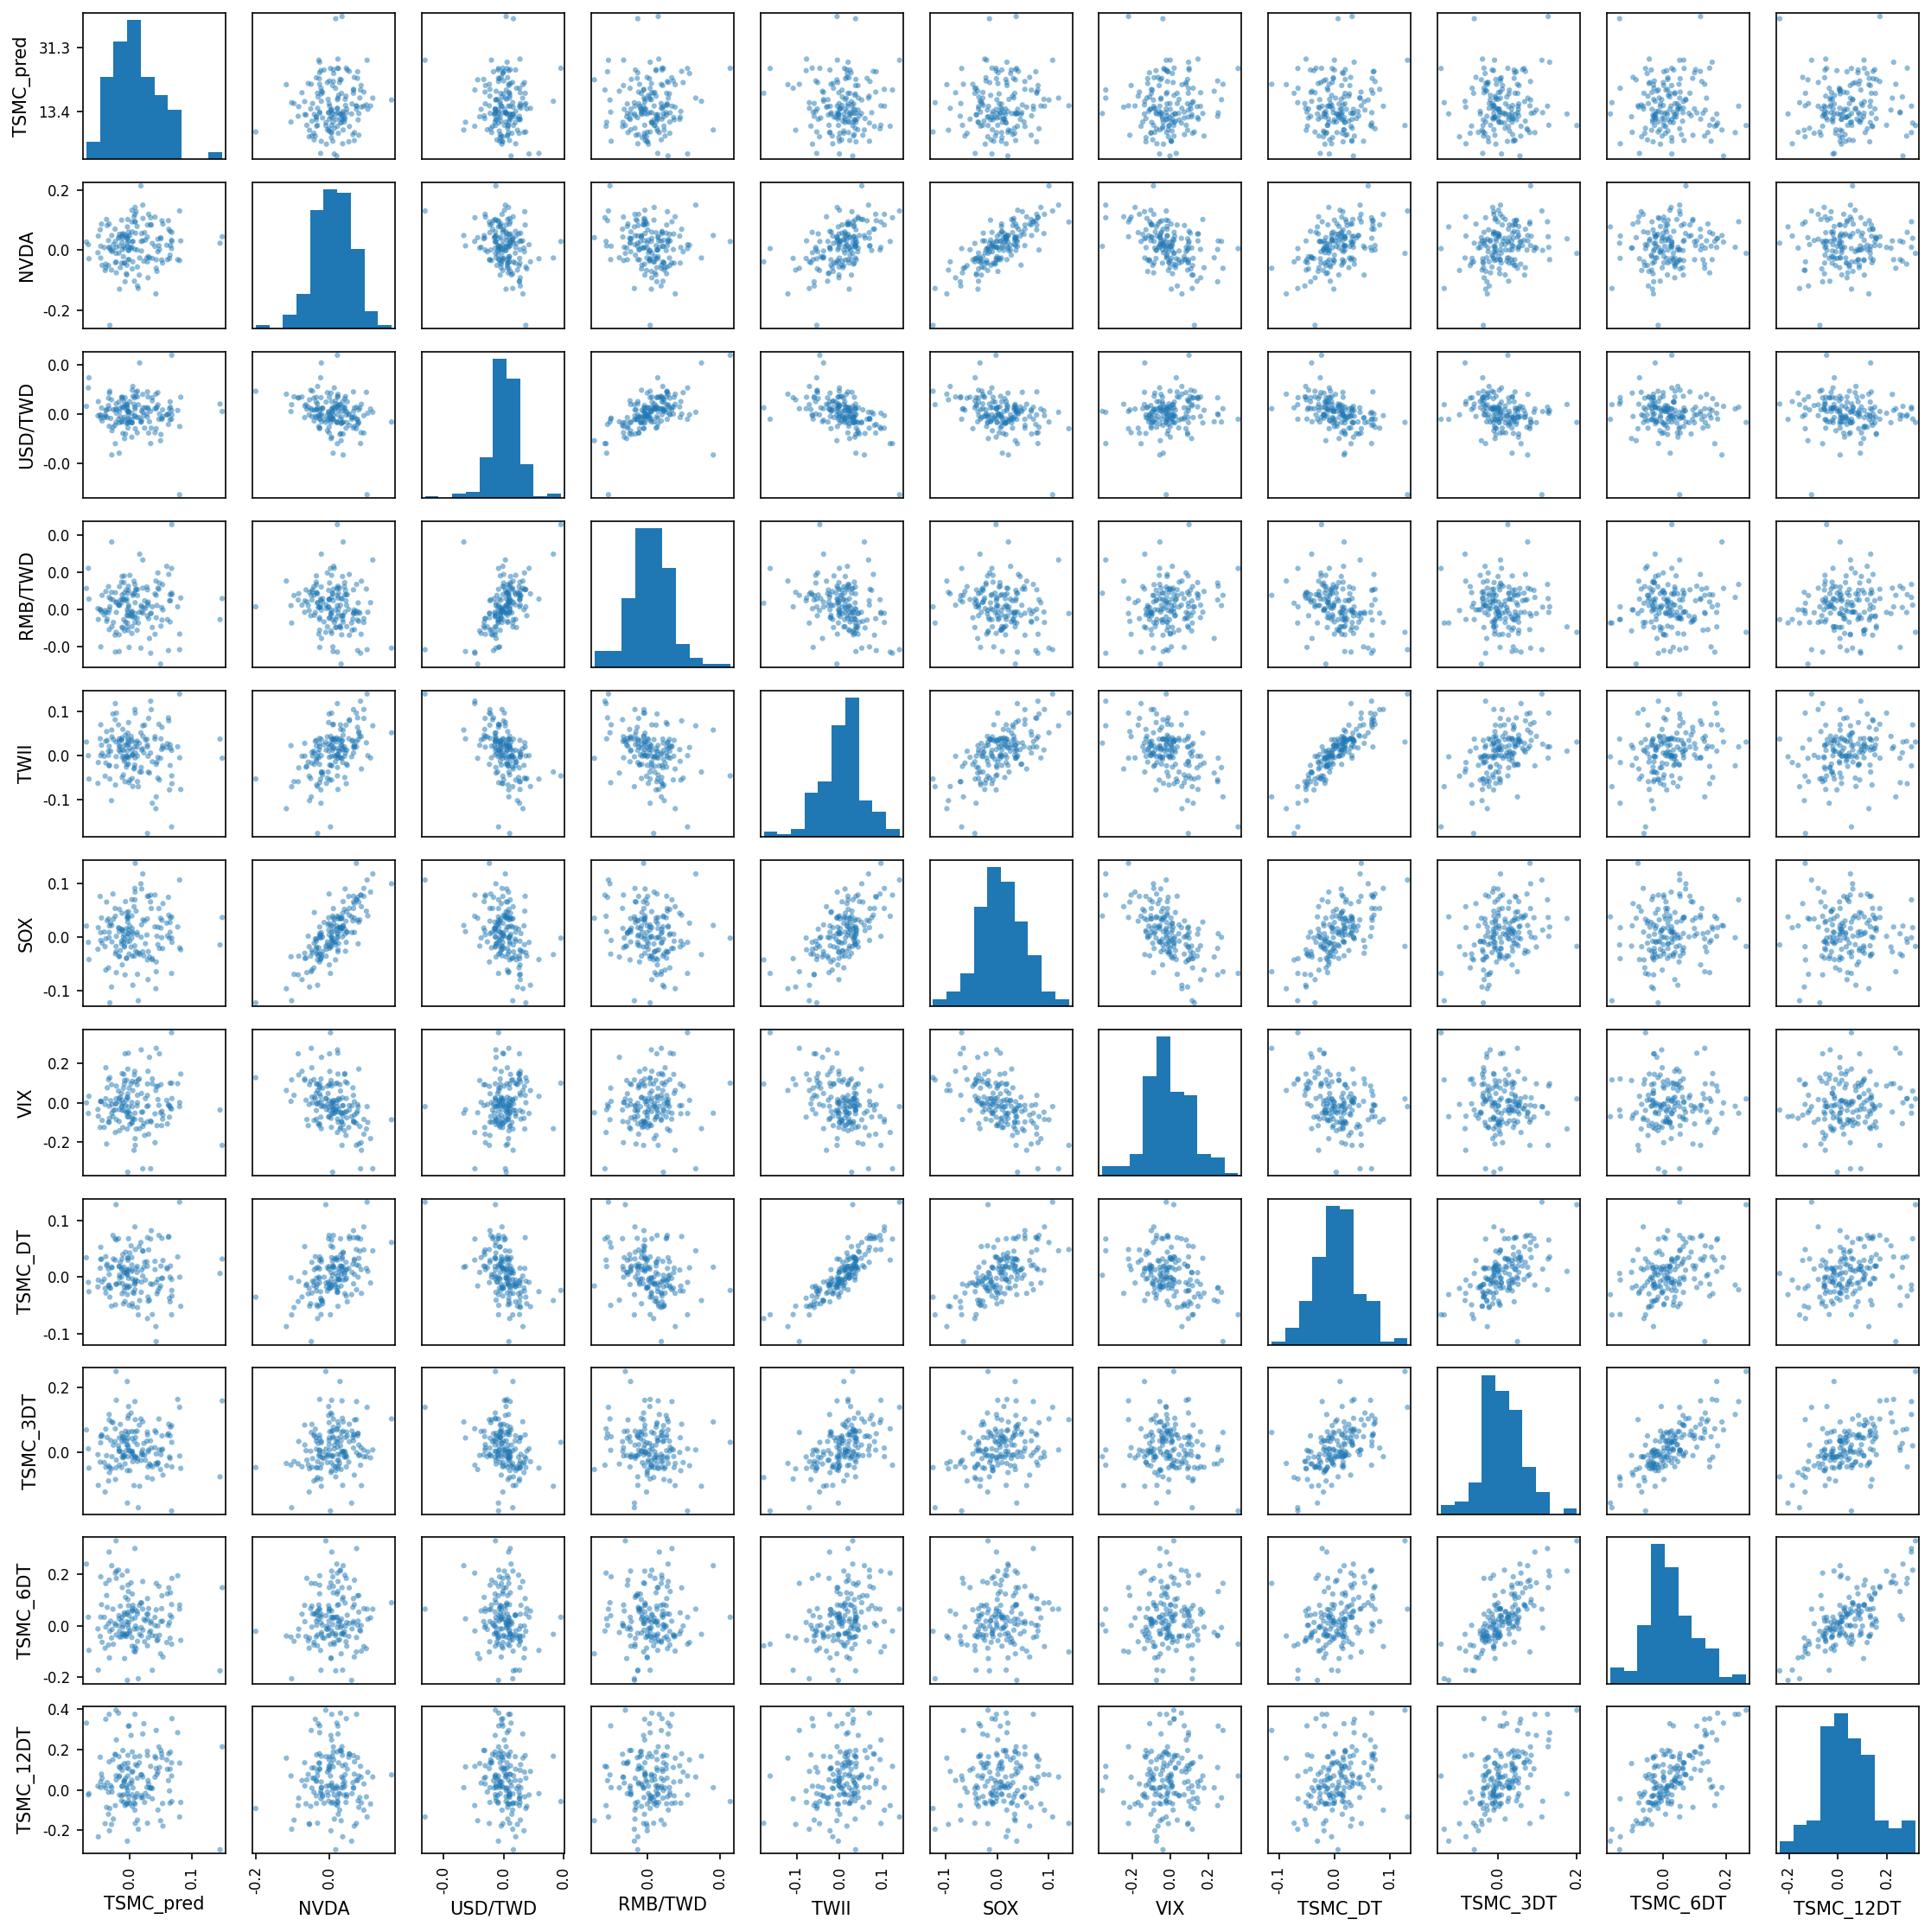

In [91]:
pyplot.figure(figsize=(15, 15))

# 設定子圖 y 軸小數顯示位數
axes = scatter_matrix(dataset, figsize=(15, 15))

# 遞迴處理所有子圖的座標軸
for ax in axes.flatten():
    # 設定 x 軸和 y 軸的格式
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

pyplot.tight_layout()
pyplot.show()

Looking at the scatter plot above, we see some linear relationship of the predicted
variable with the lagged 15 days, 30 days and 60 days return of TSMC.

<a id='2.3'></a>
## 3.3. Time Series Analysis

Next, we look at the seasonal decomposition of our time series

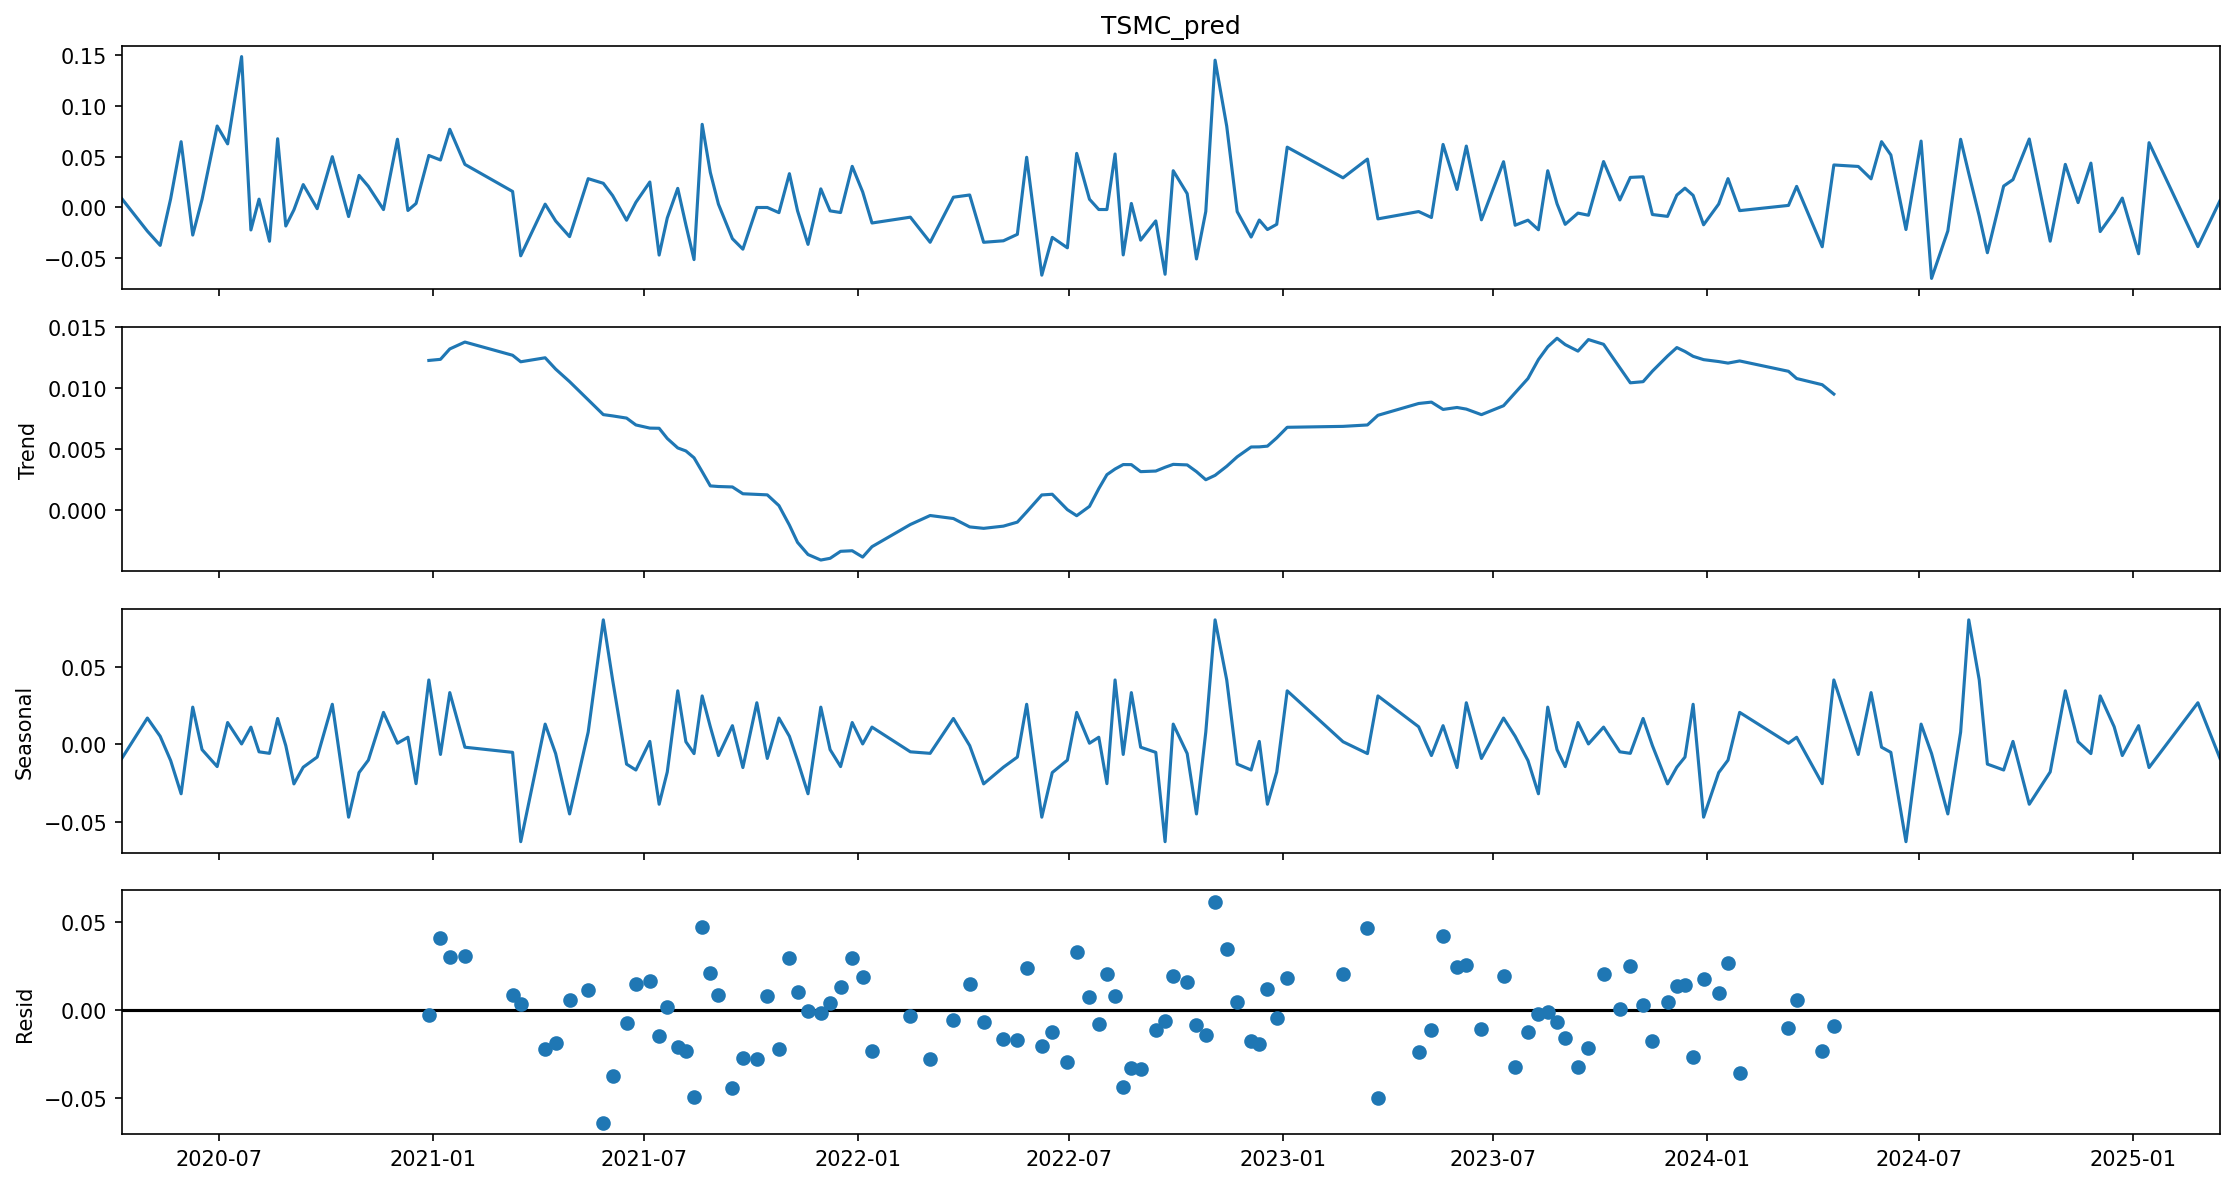

In [100]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_size_inches(15, 8)
pyplot.tight_layout()
pyplot.show()

We can see that for TSMC there has been a general trend upwards. This should show up in our the constant/bias terms in our models

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance.

In [93]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  # print 10 best features

,Score
Specs,
NVDA,2.119
SOX,1.275
TSMC_6DT,0.671
TWII,0.493
USD/TWD,0.371
RMB/TWD,0.199
VIX,0.158
TSMC_12DT,0.151
TSMC_DT,0.083


We see that NVDA seems to be the most important feature and TSMC_3DT being the least important.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [94]:
validation_size = 0.2

# In case the data is not dependent on the time series, then train and test split randomly
# seed = 11218014
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# In case the data is dependent on the time series, then train and test split should be done based on sequential sample
# This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [125]:
num_folds = 10
seed = 11218014

# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores

scoring = 'neg_mean_squared_error'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [126]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Neural Network algorithms

In [127]:
models.append(('MLP', MLPRegressor()))

##### Ensable Models

In [128]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them.  
First, we run the K-fold analysis.  
Next, we run the model on the entire training and testing dataset.

In [129]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    # K Fold analysis:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    # Converted mean square error to positive. The lower the beter
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001531 (0.000842) 0.001265 0.001497
LASSO: 0.001408 (0.000735) 0.001374 0.001454
EN: 0.001408 (0.000735) 0.001374 0.001454
KNN: 0.001652 (0.000794) 0.001090 0.001834
CART: 0.003184 (0.001272) 0.000000 0.003270
SVR: 0.002295 (0.000476) 0.002263 0.002239
MLP: 0.002025 (0.001053) 0.001611 0.002178
ABR: 0.001479 (0.000760) 0.000643 0.001639
GBR: 0.001902 (0.000933) 0.000064 0.001846
RFR: 0.001538 (0.000802) 0.000227 0.001606
ETR: 0.001599 (0.000851) 0.000000 0.001720


#### K Fold results

We being by looking at the K Fold results

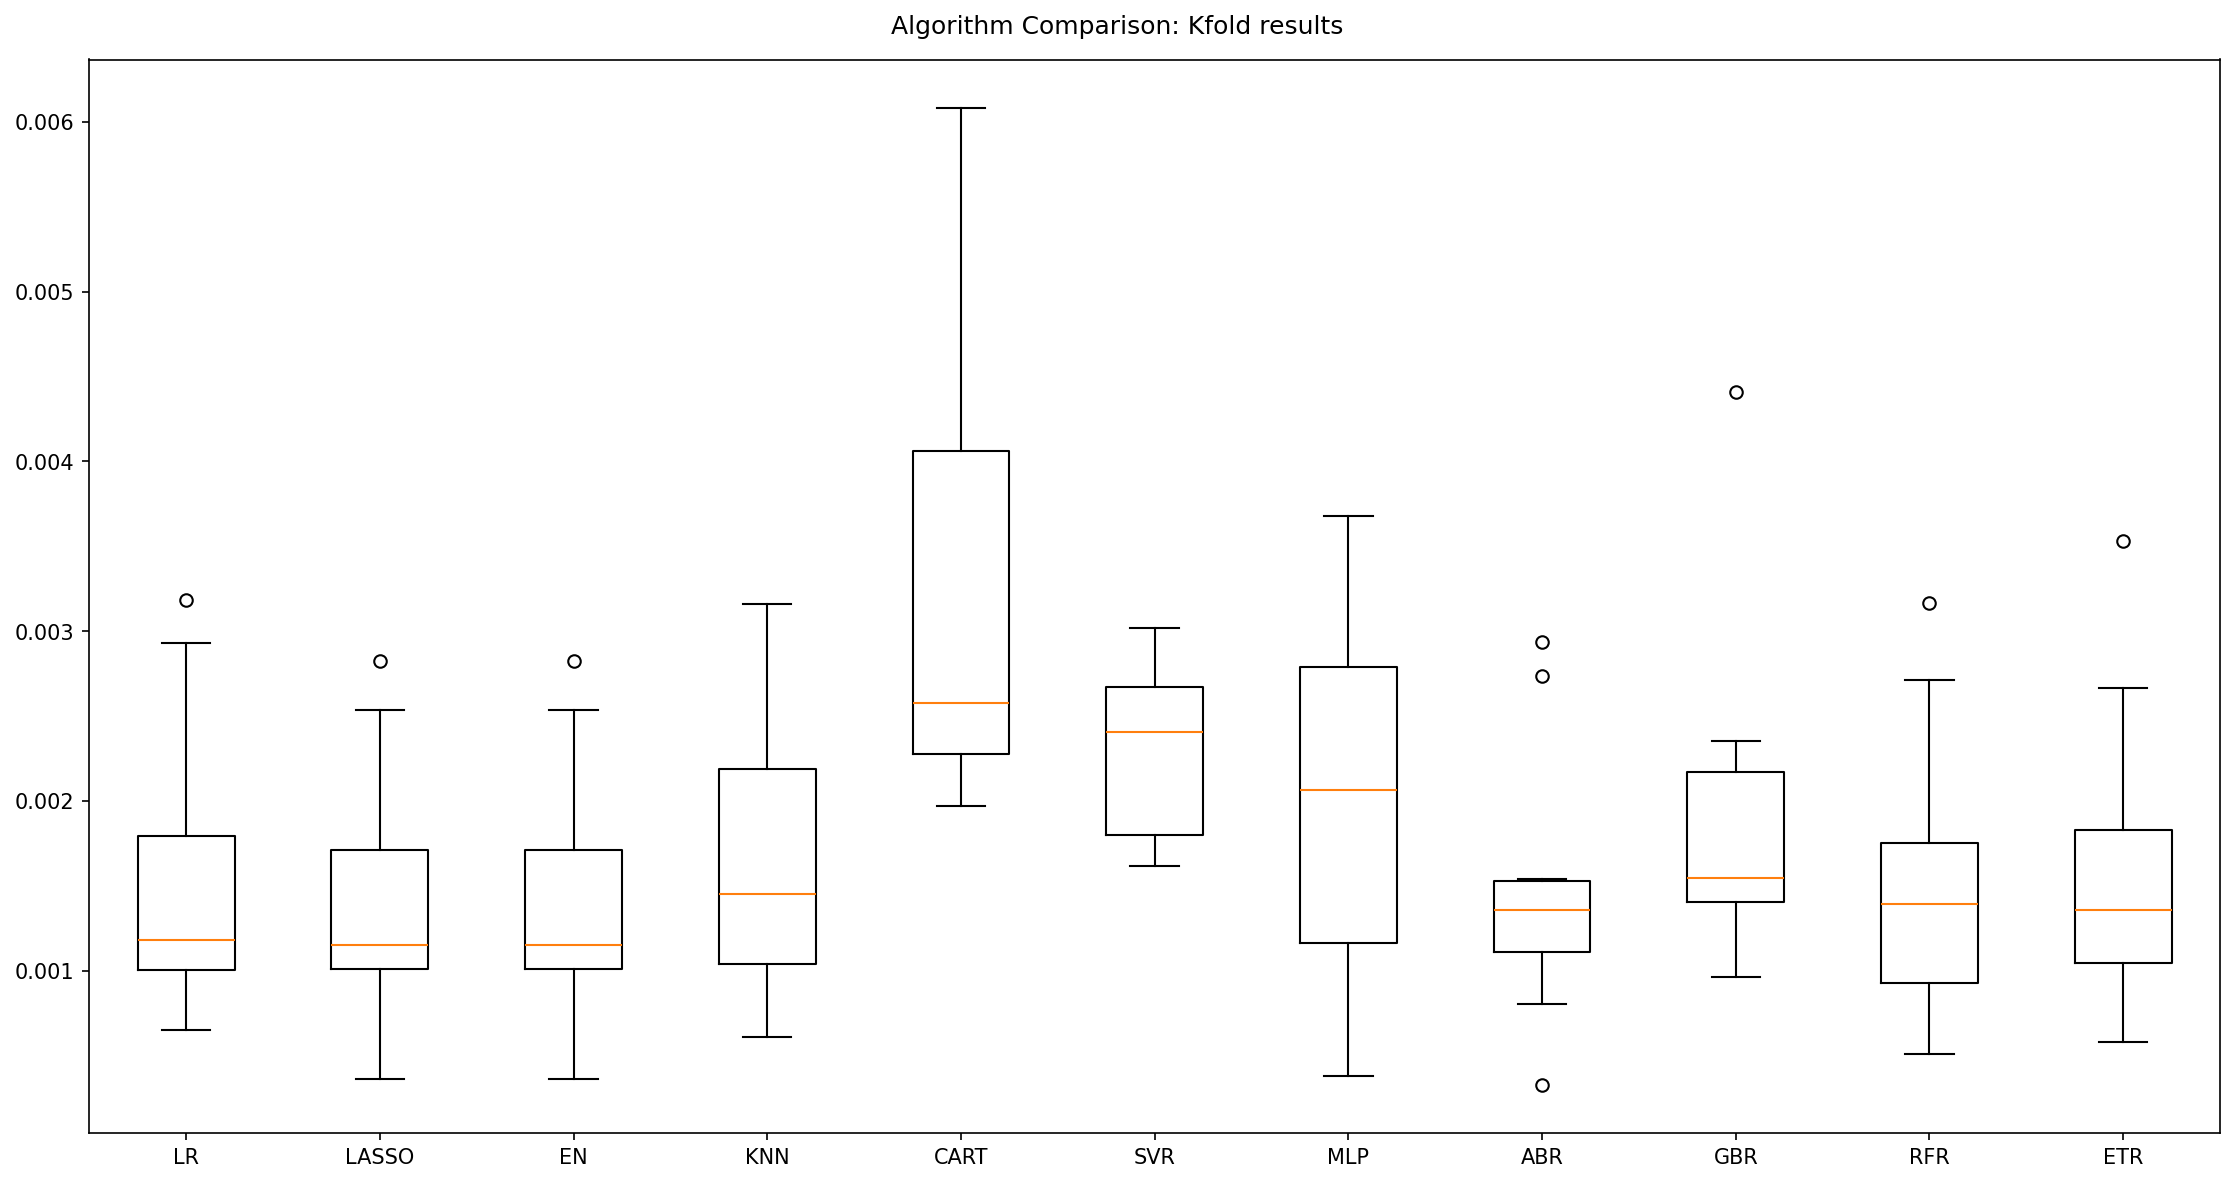

In [130]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.tight_layout()
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

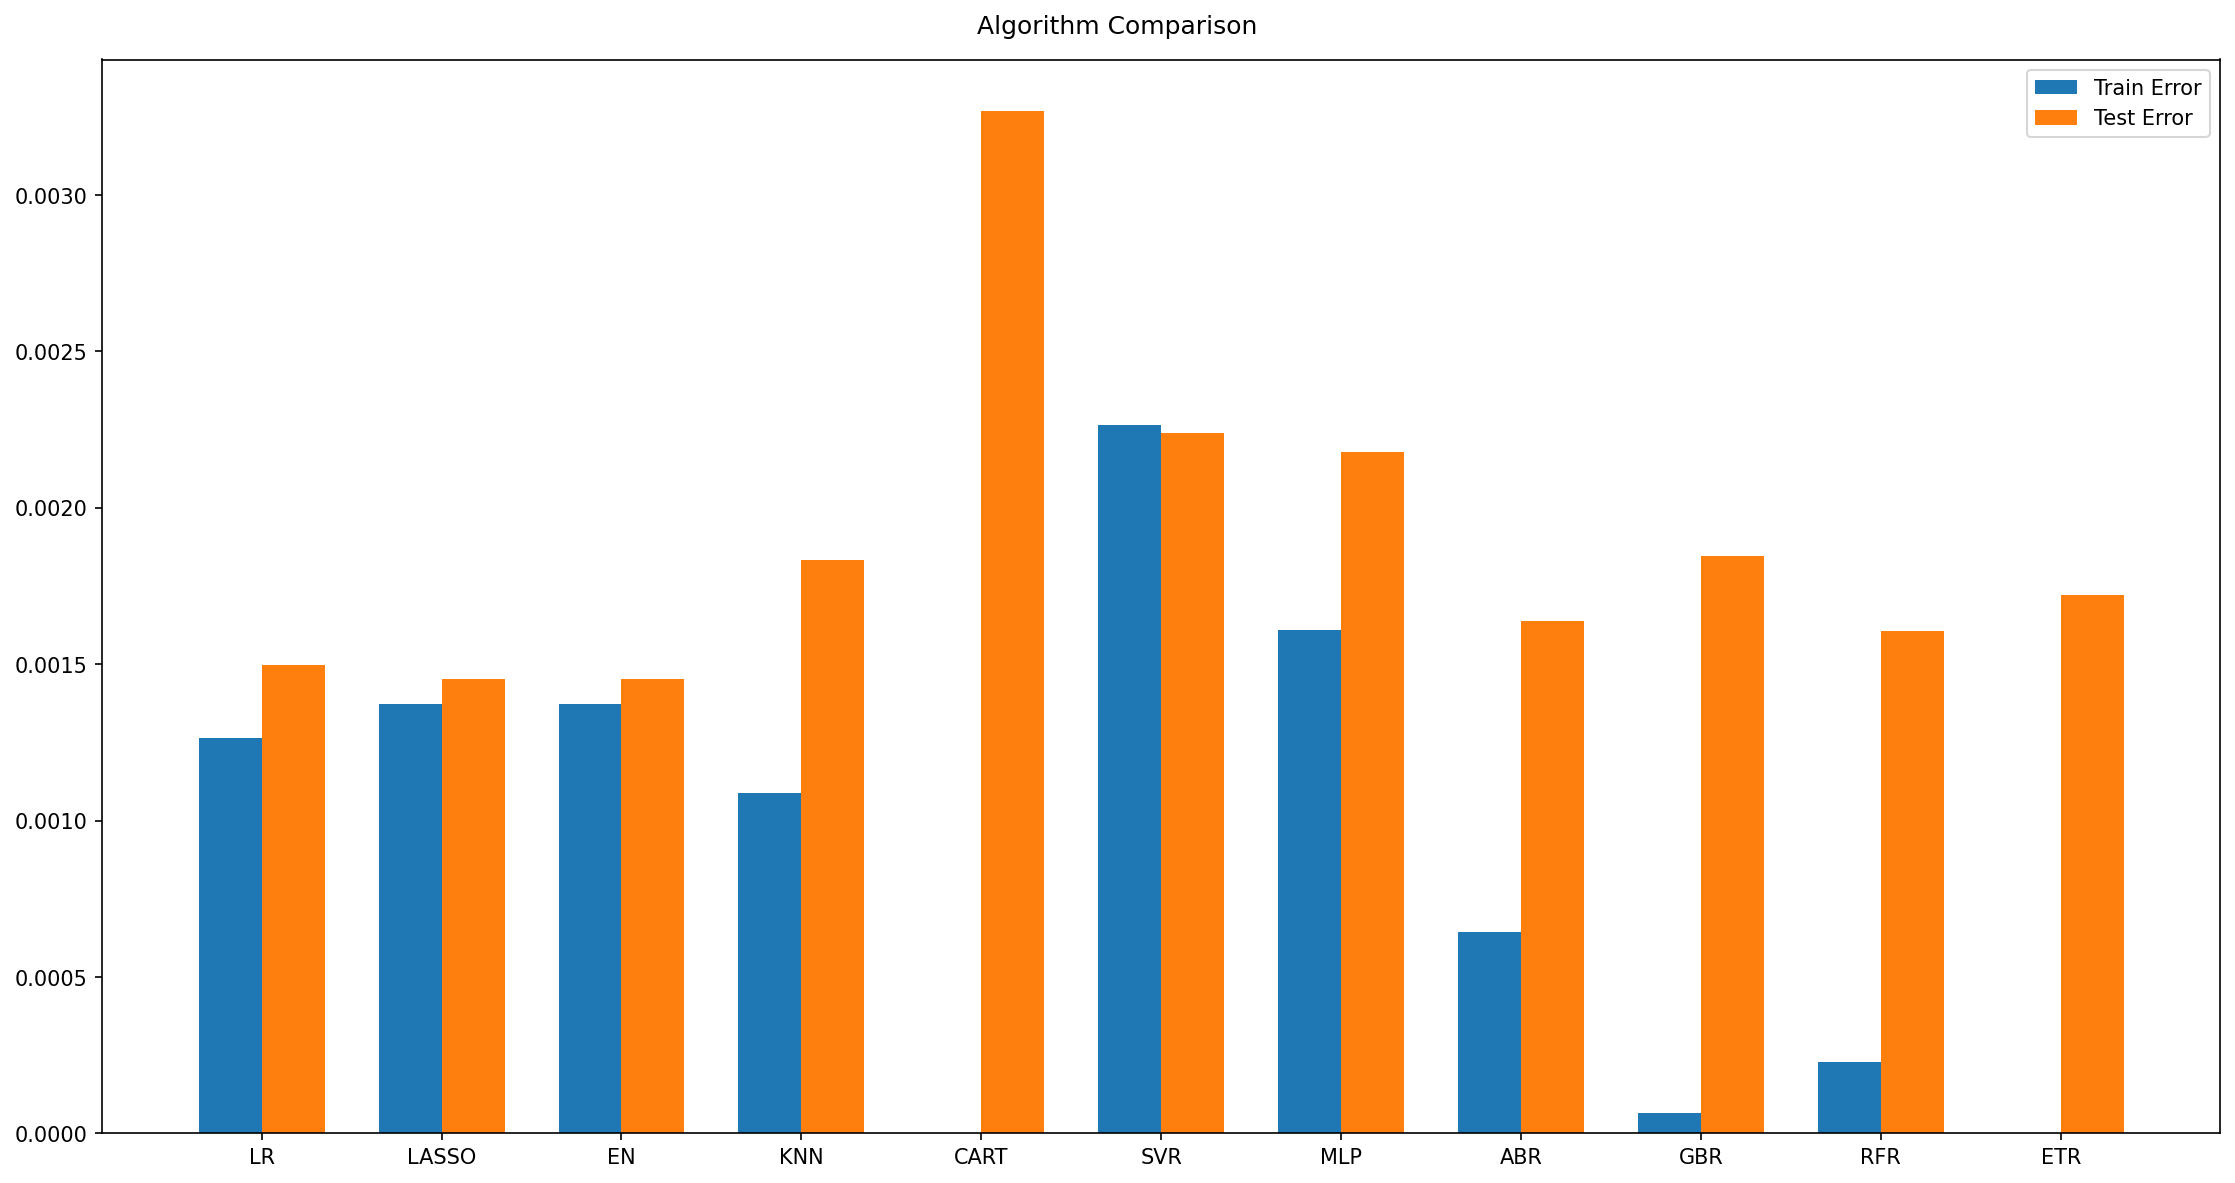

In [131]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15, 8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.tight_layout()
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models.  

Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided.  

Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance.  

We also see that the artificial neural network (shown as MLP is the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insufficient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [103]:
print(X_train)
X_train_ARIMA = X_train.loc[:, ['NVDA', 'USD/TWD', 'RMB/TWD', 'TWII', 'SOX', 'VIX']]
X_test_ARIMA = X_test.loc[:, ['NVDA', 'USD/TWD', 'RMB/TWD', 'TWII', 'SOX', 'VIX']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

                 NVDA    USD/TWD    RMB/TWD       TWII    SOX        VIX  \
2020-04-08  9.371e-02 -5.960e-03 -1.159e-03  4.787e-02  0.139 -2.748e-01   
2020-04-30  2.870e-02 -1.204e-02 -1.159e-02  5.860e-02  0.039 -1.920e-01   
2020-05-11  1.022e-01  1.675e-03 -3.268e-03  2.694e-02  0.066 -2.660e-01   
2020-05-20  1.423e-01  2.004e-03  1.764e-03 -2.789e-03  0.085 -2.315e-01   
2020-05-29 -1.684e-02 -2.330e-03 -3.438e-03  1.205e-02  0.027 -2.335e-02   
...               ...        ...        ...        ...    ...        ...   
2023-12-06 -5.625e-02  9.255e-03  5.336e-03 -5.666e-04 -0.029 -7.707e-04   
2023-12-13  5.525e-02  1.270e-03 -7.538e-04  6.214e-03  0.090 -6.202e-02   
2023-12-20  4.779e-04 -7.643e-03 -2.471e-03  9.473e-03  0.004  1.146e-01   
2023-12-29  1.407e-02 -1.588e-02 -1.144e-02  1.881e-02  0.010 -4.553e-02   
2024-01-11  1.329e-01  3.217e-04 -8.091e-04 -2.468e-04  0.040 -1.274e-01   

            TSMC_DT  TSMC_3DT  TSMC_6DT  TSMC_12DT  
2020-04-08    0.049     0.101    -

In [104]:
# ARIMA (ARIMAX)
from statsmodels.tsa.arima.model import ARIMA
modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(1, 0, 0))
model_fit = modelARIMA.fit()

In [105]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start=tr_len - 1 ,end=to_len - 1, exog=X_test_ARIMA)[1: ]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0013889785806412765

In [106]:
# SARIMAX
modelSARIMAX = SARIMAX(endog=Y_train, exog=X_train_ARIMA, order=(1, 0, 0), seasonal_order=(2, 1, 0, 12))
model_fit = modelSARIMAX.fit()

In [107]:
error_Training_SARIMAX = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start=tr_len - 1 ,end=to_len - 1, exog=X_test_ARIMA)[1: ]
error_Test_SARIMAX = mean_squared_error(Y_test,predicted)
error_Test_SARIMAX

0.0018712395184591743

###  LSTM Model

In [108]:
seq_len = 2 # Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len - 1 : ], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0] + 1 - seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[ :, i, : ] = np.array(X_train)[i:X_train.shape[0] + i + 1 - seq_len, :]
    X_test_LSTM[ :, i, : ] = np.array(X)[X_train.shape[0] + i - 1 : X.shape[0] + i + 1 - seq_len, : ]

In [109]:
# LSTM Network
def create_LSTMmodel(neurons=12, learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    # More number of cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer=optimizer)
    return model

LSTMModel = create_LSTMmodel(12, learn_rate=0.01, momentum=0.0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

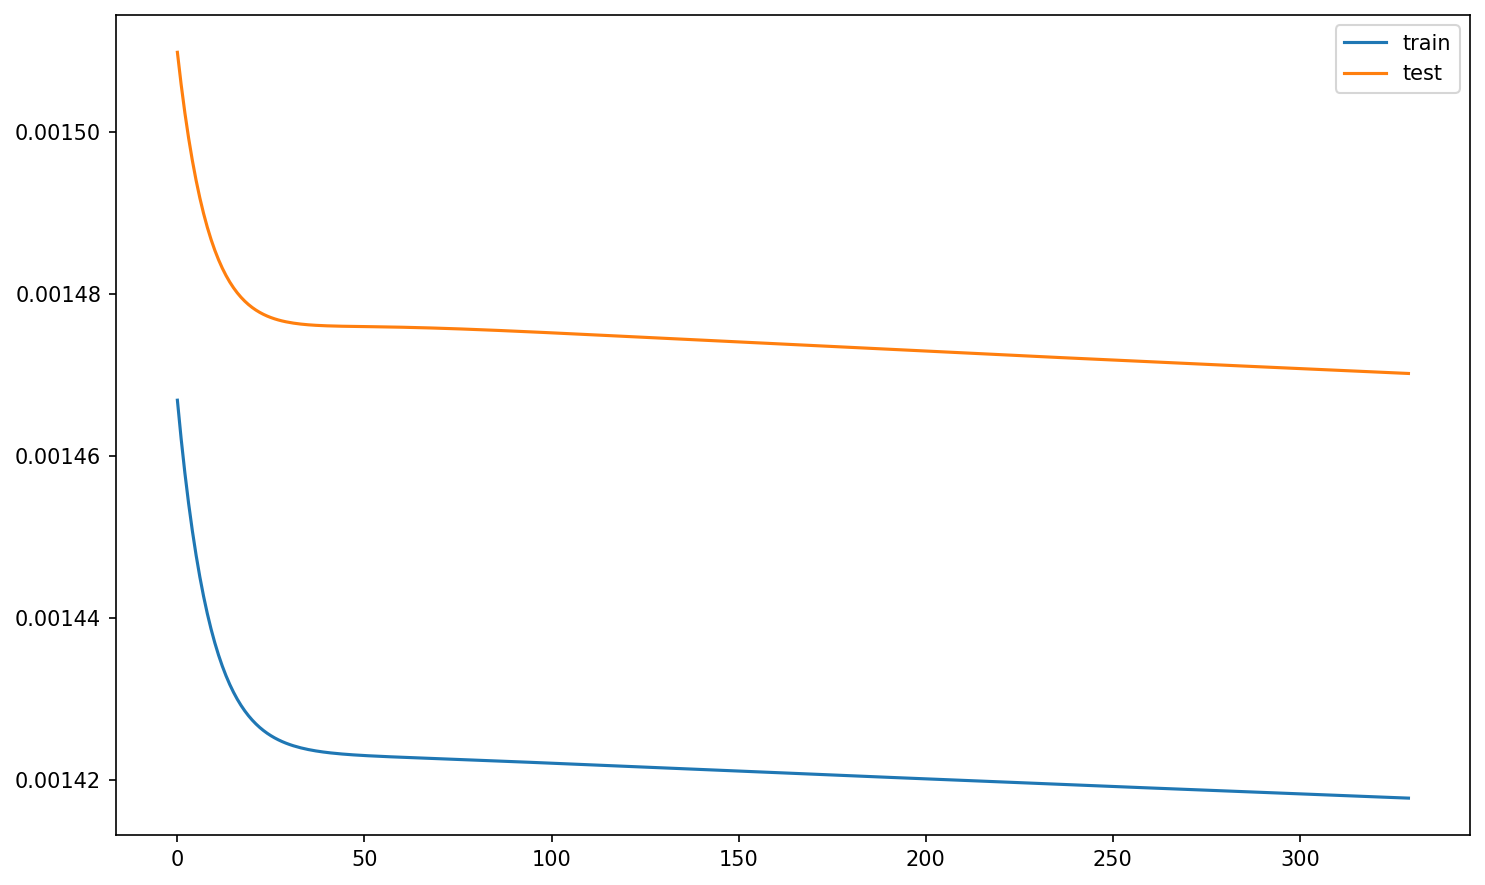

In [114]:
# Visual plot to check if the error is reducing
plt = pyplot.figure()
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
plt.set_size_inches(10, 6)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

In [115]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test, predicted)
error_Test_LSTM

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


0.0014701988548747379

#### Append to previous results

In [116]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Overall Comparison of all the algorithms (including Time Series Algorithms)

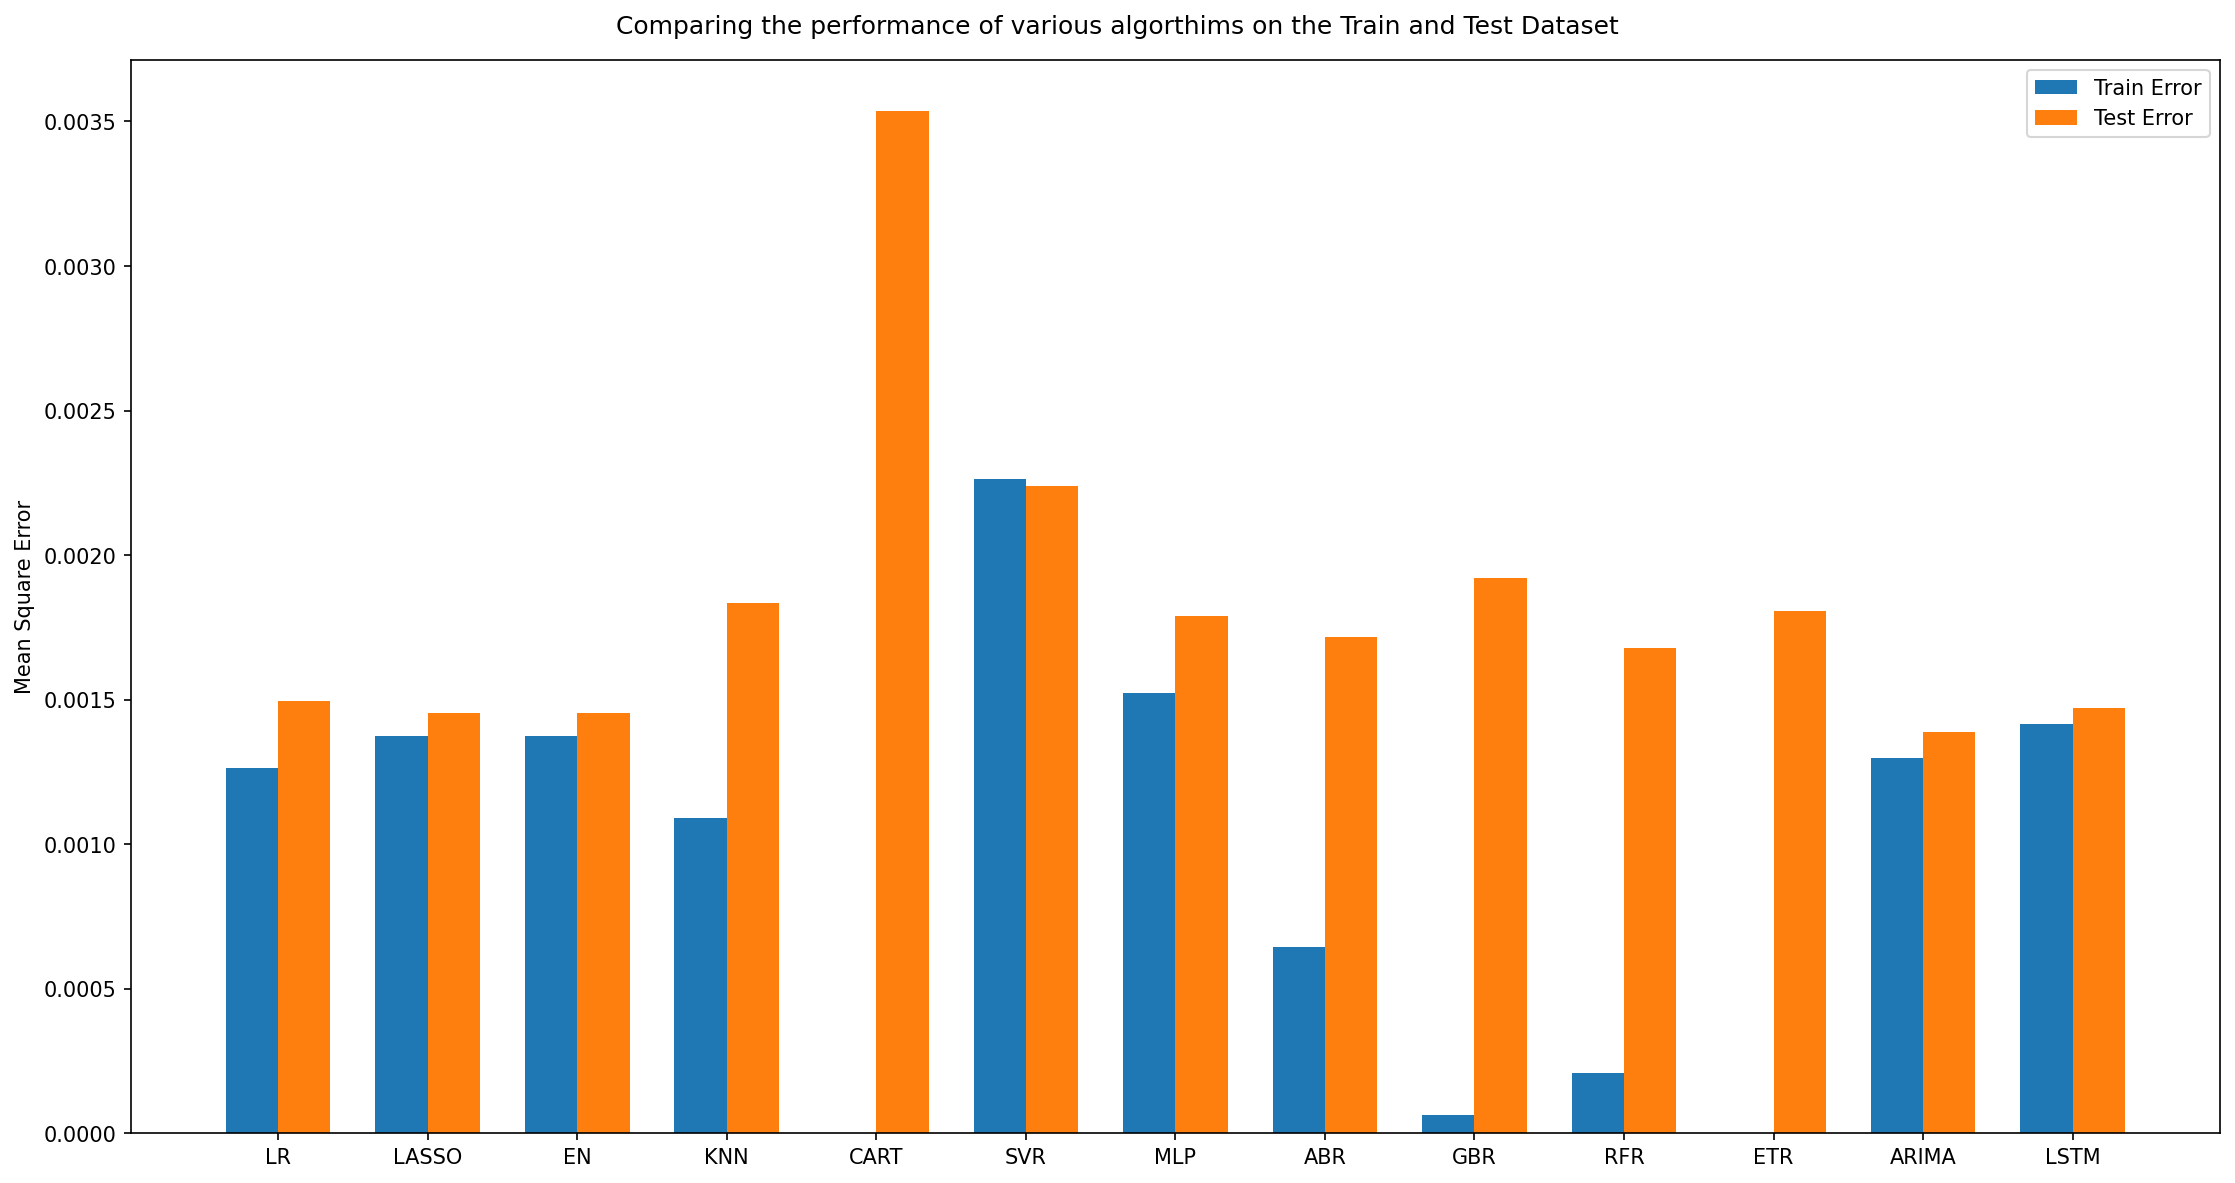

In [117]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15, 8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.tight_layout()
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regression (LASSO) and Elastic Net (EN).

This can primarily be due to the strong linear relationship as discussed before. The LSTM model performs decently, however, ARIMA model outperforms the LSTM model in the test set.

Hence, we select the ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model.

The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p, d and q in the ARIMA model's order.  

In [118]:
# Grid Search for ARIMA Model
# Change p, d and q and check for the best result

# evaluate an ARIMA model for a given order (p, d, q)
# Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()
    modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0013095
ARIMA(0, 0, 1) MSE=0.0012963
ARIMA(0, 1, 0) MSE=0.0022522
ARIMA(0, 1, 1) MSE=0.0013691
ARIMA(1, 0, 0) MSE=0.0012968
ARIMA(1, 0, 1) MSE=0.0012980
ARIMA(1, 1, 0) MSE=0.0019036
ARIMA(1, 1, 1) MSE=0.0013650
ARIMA(2, 0, 0) MSE=0.0012949
ARIMA(2, 0, 1) MSE=0.0012956
ARIMA(2, 1, 0) MSE=0.0017932
ARIMA(2, 1, 1) MSE=0.0013625
Best ARIMA(2, 0, 0) MSE=0.0012949


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [119]:
# prepare model
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[2,0,0])
model_fit_tuned = modelARIMA_tuned.fit()

In [120]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start=tr_len - 1, end=to_len - 1, exog=X_test_ARIMA)[1 : ]
print(mean_squared_error(Y_test,predicted_tuned))

0.0018712395184591743


After tuning the model and picking the best ARIMA model or the order 2, 0 and 1, we select this model and can it can be used for the modeling purpose.

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [121]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

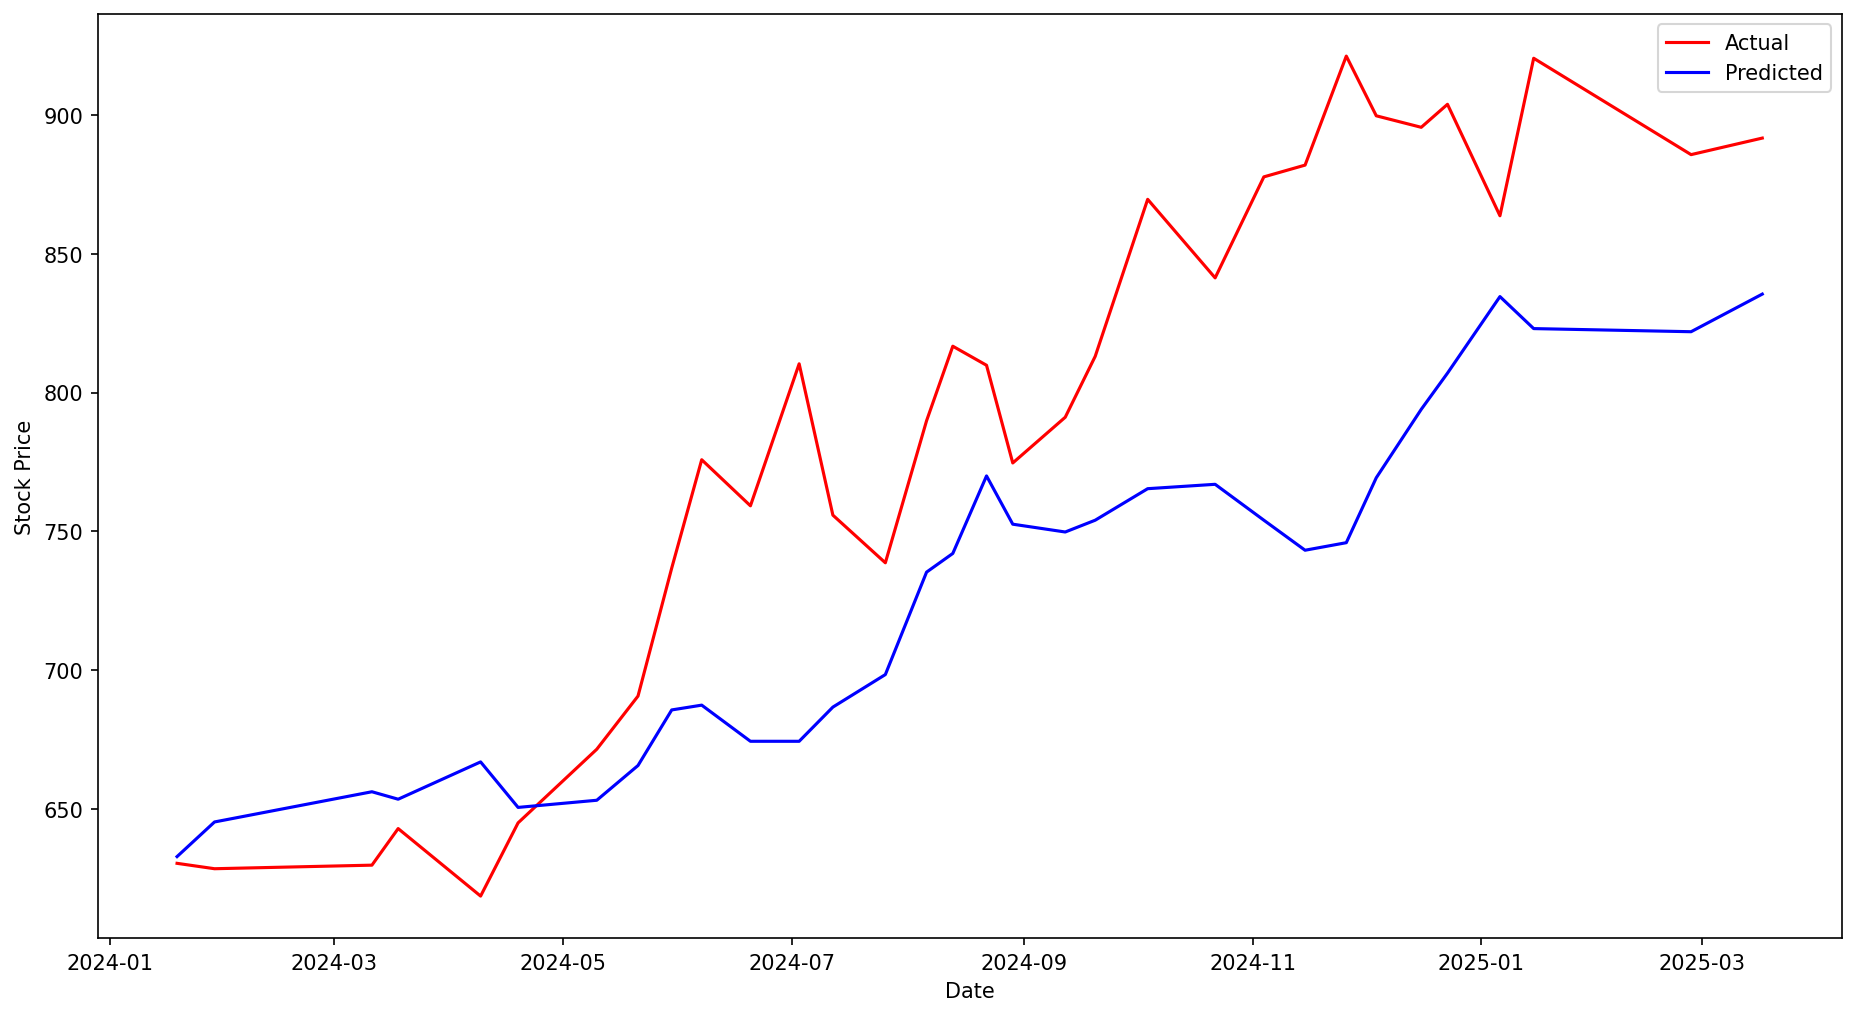

In [124]:
initial_price = stk_data.loc[Y_test.index[0], ('Close', '2330.TW')]  # Get initial price from stk_data

# Calculate actual prices from returns
actual_prices = initial_price * np.exp(Y_test).cumprod()

# Calculate predicted prices from predicted returns
predicted_tuned.index = Y_test.index
predicted_prices = initial_price * np.exp(predicted_tuned).cumprod()

# Plotting
plt = pyplot.figure()
pyplot.plot(actual_prices, 'r', label='Actual')
pyplot.plot(predicted_prices, 'b', label='Predicted')
plt.set_size_inches(15, 8)
pyplot.xlabel('Date')
pyplot.ylabel('Stock Price')  # Update y-axis label
pyplot.legend()
pyplot.show()

### Summary

This case study explored various machine learning and time series models to predict the weekly returns of Taiwan Semiconductor Manufacturing Company (TSMC) stock. We utilized potentially correlated assets, including NVIDIA stock, USD/TWD and RMB/TWD exchange rates, and indices like TWII, SOX, and VIX, alongside TSMC's historical data.

Our analysis revealed that linear models such as Linear Regression, Lasso Regression, and Elastic Net, along with the time series model ARIMA, demonstrated promising performance in predicting TSMC stock returns. These models effectively captured the linear relationships within the dataset and offered a flexible approach for modeling time dependencies.

While exploring various algorithms, we observed that some models, like the Decision Tree Regressor, tended to overfit the training data, resulting in higher errors on the test set. Ensemble models like Gradient Boosting Regression and Random Forest Regression showed potential but exhibited higher variance. Notably, the ARIMA model emerged as a top performer, comparable to the linear models, likely due to the strong linear relationships present in the data. Although the LSTM model was explored, ARIMA outperformed it in the test set.

Further investigation using feature selection techniques indicated the significance of NVIDIA stock returns and other factors in predicting TSMC returns. Through grid search and model tuning, we identified an optimal ARIMA model configuration.

This study demonstrates the effectiveness of combining supervised regression and time series modeling frameworks for asset price prediction. Using historical data and exploring relevant indicators allow us to generate predictive results and analyze potential risks and profitability before deploying capital.

Future improvements could involve incorporating a broader range of indicators, such as P/E ratio, trading volume, technical indicators, and news sentiment, which might further enhance predictive accuracy.

Overall, this framework provides a valuable tool for financial practitioners to model and predict asset price movements, supporting informed decision-making in financial markets.